In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
output_notebook()
%matplotlib inline

Loading BokehJS ...

### Dados
- são carregados os dados pre-procesados no notebook: Data pre-processing

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [4]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [5]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r
    

In [6]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [7]:
X_cand = datos.drop(rg)
X_cand.shape

(4185, 9)

In [8]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4185, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [9]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [10]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [12]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


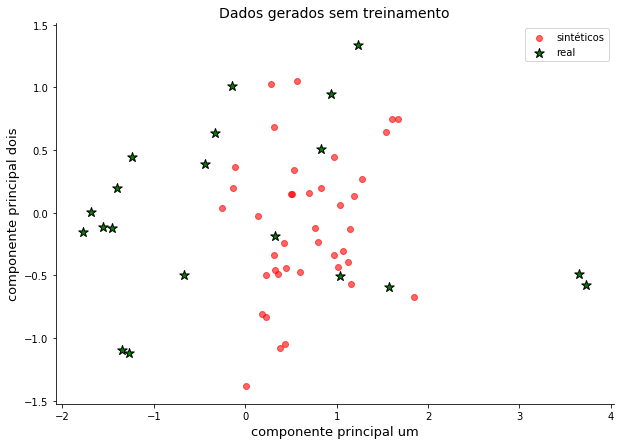

In [13]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0]*2, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [14]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(Dropout(.1))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [15]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [17]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [18]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    precision = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, precision

In [19]:
noise_input = 50
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/1500)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/1500)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [20]:
ep = 1500
g_loss, d_loss, precision = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/1500] [Discriminator::d_loss: 0.707403],[Generator::loss: 0.757069], 0.748314[sec]
epoch:[2/1500] [Discriminator::d_loss: 0.706806],[Generator::loss: 0.707031], 0.008456[sec]
epoch:[3/1500] [Discriminator::d_loss: 0.718600],[Generator::loss: 0.711964], 0.008677[sec]
epoch:[4/1500] [Discriminator::d_loss: 0.715807],[Generator::loss: 0.798119], 0.008616[sec]
epoch:[5/1500] [Discriminator::d_loss: 0.718926],[Generator::loss: 0.775646], 0.008490[sec]
epoch:[6/1500] [Discriminator::d_loss: 0.692112],[Generator::loss: 0.771793], 0.008655[sec]
epoch:[7/1500] [Discriminator::d_loss: 0.693392],[Generator::loss: 0.754786], 0.008471[sec]
epoch:[8/1500] [Discriminator::d_loss: 0.703106],[Generator::loss: 0.750142], 0.008452[sec]
epoch:[9/1500] [Discriminator::d_loss: 0.716728],[Generator::loss: 0.746524], 0.008268[sec]
epoch:[10/1500] [Discriminator::d_loss: 0.684497],[Generator::loss: 0.729786], 0.008354[sec]
epoch:[11/1500] [Discriminator::d_loss: 0.726449],[Generator::loss: 0.764592], 

epoch:[89/1500] [Discriminator::d_loss: 0.673644],[Generator::loss: 0.738826], 0.013752[sec]
epoch:[90/1500] [Discriminator::d_loss: 0.651179],[Generator::loss: 0.715005], 0.010709[sec]
epoch:[91/1500] [Discriminator::d_loss: 0.662476],[Generator::loss: 0.730142], 0.010315[sec]
epoch:[92/1500] [Discriminator::d_loss: 0.669272],[Generator::loss: 0.723465], 0.014966[sec]
epoch:[93/1500] [Discriminator::d_loss: 0.658504],[Generator::loss: 0.705568], 0.009282[sec]
epoch:[94/1500] [Discriminator::d_loss: 0.667922],[Generator::loss: 0.726973], 0.010052[sec]
epoch:[95/1500] [Discriminator::d_loss: 0.676884],[Generator::loss: 0.744517], 0.009240[sec]
epoch:[96/1500] [Discriminator::d_loss: 0.684136],[Generator::loss: 0.679331], 0.008426[sec]
epoch:[97/1500] [Discriminator::d_loss: 0.659220],[Generator::loss: 0.755137], 0.009805[sec]
epoch:[98/1500] [Discriminator::d_loss: 0.668216],[Generator::loss: 0.703596], 0.008970[sec]
epoch:[99/1500] [Discriminator::d_loss: 0.654536],[Generator::loss: 0.

epoch:[189/1500] [Discriminator::d_loss: 0.629419],[Generator::loss: 0.729385], 0.010843[sec]
epoch:[190/1500] [Discriminator::d_loss: 0.626151],[Generator::loss: 0.696286], 0.008611[sec]
epoch:[191/1500] [Discriminator::d_loss: 0.642539],[Generator::loss: 0.751237], 0.008438[sec]
epoch:[192/1500] [Discriminator::d_loss: 0.650314],[Generator::loss: 0.798935], 0.008708[sec]
epoch:[193/1500] [Discriminator::d_loss: 0.646927],[Generator::loss: 0.771161], 0.008575[sec]
epoch:[194/1500] [Discriminator::d_loss: 0.656064],[Generator::loss: 0.692621], 0.008648[sec]
epoch:[195/1500] [Discriminator::d_loss: 0.659447],[Generator::loss: 0.781830], 0.008555[sec]
epoch:[196/1500] [Discriminator::d_loss: 0.667110],[Generator::loss: 0.761090], 0.008798[sec]
epoch:[197/1500] [Discriminator::d_loss: 0.645376],[Generator::loss: 0.709007], 0.008526[sec]
epoch:[198/1500] [Discriminator::d_loss: 0.625473],[Generator::loss: 0.714033], 0.008659[sec]
epoch:[199/1500] [Discriminator::d_loss: 0.610806],[Generato

epoch:[298/1500] [Discriminator::d_loss: 0.604210],[Generator::loss: 0.740190], 0.009273[sec]
epoch:[299/1500] [Discriminator::d_loss: 0.589149],[Generator::loss: 0.787502], 0.008492[sec]
epoch:[300/1500] [Discriminator::d_loss: 0.631654],[Generator::loss: 0.795908], 0.008321[sec]
epoch:[301/1500] [Discriminator::d_loss: 0.611136],[Generator::loss: 0.793373], 0.008359[sec]
epoch:[302/1500] [Discriminator::d_loss: 0.595249],[Generator::loss: 0.792458], 0.008400[sec]
epoch:[303/1500] [Discriminator::d_loss: 0.585074],[Generator::loss: 0.738299], 0.008229[sec]
epoch:[304/1500] [Discriminator::d_loss: 0.603250],[Generator::loss: 0.784531], 0.008543[sec]
epoch:[305/1500] [Discriminator::d_loss: 0.628007],[Generator::loss: 0.719237], 0.008448[sec]
epoch:[306/1500] [Discriminator::d_loss: 0.618003],[Generator::loss: 0.727270], 0.008399[sec]
epoch:[307/1500] [Discriminator::d_loss: 0.612591],[Generator::loss: 0.726180], 0.008316[sec]
epoch:[308/1500] [Discriminator::d_loss: 0.649753],[Generato

epoch:[388/1500] [Discriminator::d_loss: 0.584891],[Generator::loss: 0.873750], 0.009529[sec]
epoch:[389/1500] [Discriminator::d_loss: 0.602094],[Generator::loss: 0.700936], 0.010942[sec]
epoch:[390/1500] [Discriminator::d_loss: 0.583814],[Generator::loss: 0.780113], 0.008719[sec]
epoch:[391/1500] [Discriminator::d_loss: 0.592668],[Generator::loss: 0.827796], 0.008821[sec]
epoch:[392/1500] [Discriminator::d_loss: 0.561722],[Generator::loss: 0.851591], 0.009220[sec]
epoch:[393/1500] [Discriminator::d_loss: 0.582432],[Generator::loss: 0.719236], 0.008801[sec]
epoch:[394/1500] [Discriminator::d_loss: 0.561765],[Generator::loss: 0.688773], 0.008293[sec]
epoch:[395/1500] [Discriminator::d_loss: 0.608650],[Generator::loss: 0.759298], 0.008568[sec]
epoch:[396/1500] [Discriminator::d_loss: 0.606700],[Generator::loss: 0.824176], 0.009182[sec]
epoch:[397/1500] [Discriminator::d_loss: 0.607231],[Generator::loss: 0.802872], 0.010664[sec]
epoch:[398/1500] [Discriminator::d_loss: 0.620557],[Generato

epoch:[488/1500] [Discriminator::d_loss: 0.577212],[Generator::loss: 0.784062], 0.016930[sec]
epoch:[489/1500] [Discriminator::d_loss: 0.564951],[Generator::loss: 0.812092], 0.010806[sec]
epoch:[490/1500] [Discriminator::d_loss: 0.577437],[Generator::loss: 0.852531], 0.009483[sec]
epoch:[491/1500] [Discriminator::d_loss: 0.599022],[Generator::loss: 0.780830], 0.009120[sec]
epoch:[492/1500] [Discriminator::d_loss: 0.551604],[Generator::loss: 0.863029], 0.008574[sec]
epoch:[493/1500] [Discriminator::d_loss: 0.563355],[Generator::loss: 0.829434], 0.010318[sec]
epoch:[494/1500] [Discriminator::d_loss: 0.550820],[Generator::loss: 0.870605], 0.008471[sec]
epoch:[495/1500] [Discriminator::d_loss: 0.585664],[Generator::loss: 0.881734], 0.009346[sec]
epoch:[496/1500] [Discriminator::d_loss: 0.580293],[Generator::loss: 0.864373], 0.008204[sec]
epoch:[497/1500] [Discriminator::d_loss: 0.578472],[Generator::loss: 0.841752], 0.009057[sec]
epoch:[498/1500] [Discriminator::d_loss: 0.567075],[Generato

epoch:[590/1500] [Discriminator::d_loss: 0.542247],[Generator::loss: 0.738115], 0.010237[sec]
epoch:[591/1500] [Discriminator::d_loss: 0.590812],[Generator::loss: 0.821338], 0.008675[sec]
epoch:[592/1500] [Discriminator::d_loss: 0.618314],[Generator::loss: 0.830203], 0.008486[sec]
epoch:[593/1500] [Discriminator::d_loss: 0.597510],[Generator::loss: 0.747093], 0.008454[sec]
epoch:[594/1500] [Discriminator::d_loss: 0.625655],[Generator::loss: 0.864268], 0.008222[sec]
epoch:[595/1500] [Discriminator::d_loss: 0.576338],[Generator::loss: 0.863164], 0.008400[sec]
epoch:[596/1500] [Discriminator::d_loss: 0.583943],[Generator::loss: 0.869889], 0.008539[sec]
epoch:[597/1500] [Discriminator::d_loss: 0.550127],[Generator::loss: 0.753827], 0.008288[sec]
epoch:[598/1500] [Discriminator::d_loss: 0.569597],[Generator::loss: 0.896615], 0.008110[sec]
epoch:[599/1500] [Discriminator::d_loss: 0.553158],[Generator::loss: 0.820899], 0.008818[sec]
epoch:[600/1500] [Discriminator::d_loss: 0.589672],[Generato

epoch:[683/1500] [Discriminator::d_loss: 0.598065],[Generator::loss: 0.855209], 0.009668[sec]
epoch:[684/1500] [Discriminator::d_loss: 0.560502],[Generator::loss: 0.925705], 0.008661[sec]
epoch:[685/1500] [Discriminator::d_loss: 0.554685],[Generator::loss: 0.866724], 0.008315[sec]
epoch:[686/1500] [Discriminator::d_loss: 0.573020],[Generator::loss: 0.835180], 0.008523[sec]
epoch:[687/1500] [Discriminator::d_loss: 0.620813],[Generator::loss: 0.788560], 0.008384[sec]
epoch:[688/1500] [Discriminator::d_loss: 0.545819],[Generator::loss: 0.879378], 0.009091[sec]
epoch:[689/1500] [Discriminator::d_loss: 0.578023],[Generator::loss: 0.918833], 0.008350[sec]
epoch:[690/1500] [Discriminator::d_loss: 0.576959],[Generator::loss: 0.867166], 0.008820[sec]
epoch:[691/1500] [Discriminator::d_loss: 0.588047],[Generator::loss: 0.754741], 0.008295[sec]
epoch:[692/1500] [Discriminator::d_loss: 0.579931],[Generator::loss: 0.731271], 0.008596[sec]
epoch:[693/1500] [Discriminator::d_loss: 0.596649],[Generato

epoch:[772/1500] [Discriminator::d_loss: 0.603060],[Generator::loss: 0.990272], 0.010925[sec]
epoch:[773/1500] [Discriminator::d_loss: 0.599093],[Generator::loss: 0.856004], 0.008478[sec]
epoch:[774/1500] [Discriminator::d_loss: 0.580826],[Generator::loss: 0.889789], 0.008554[sec]
epoch:[775/1500] [Discriminator::d_loss: 0.572860],[Generator::loss: 0.788631], 0.008569[sec]
epoch:[776/1500] [Discriminator::d_loss: 0.600646],[Generator::loss: 0.801737], 0.008507[sec]
epoch:[777/1500] [Discriminator::d_loss: 0.569287],[Generator::loss: 0.928766], 0.008706[sec]
epoch:[778/1500] [Discriminator::d_loss: 0.602745],[Generator::loss: 0.821479], 0.008495[sec]
epoch:[779/1500] [Discriminator::d_loss: 0.588936],[Generator::loss: 0.847187], 0.008457[sec]
epoch:[780/1500] [Discriminator::d_loss: 0.587041],[Generator::loss: 0.861581], 0.008246[sec]
epoch:[781/1500] [Discriminator::d_loss: 0.577896],[Generator::loss: 0.934164], 0.008298[sec]
epoch:[782/1500] [Discriminator::d_loss: 0.610013],[Generato

epoch:[864/1500] [Discriminator::d_loss: 0.593598],[Generator::loss: 0.825960], 0.010393[sec]
epoch:[865/1500] [Discriminator::d_loss: 0.565391],[Generator::loss: 0.864613], 0.008739[sec]
epoch:[866/1500] [Discriminator::d_loss: 0.567174],[Generator::loss: 0.878384], 0.008689[sec]
epoch:[867/1500] [Discriminator::d_loss: 0.624773],[Generator::loss: 0.880893], 0.008594[sec]
epoch:[868/1500] [Discriminator::d_loss: 0.592657],[Generator::loss: 0.902814], 0.008858[sec]
epoch:[869/1500] [Discriminator::d_loss: 0.617296],[Generator::loss: 0.873660], 0.008428[sec]
epoch:[870/1500] [Discriminator::d_loss: 0.602542],[Generator::loss: 0.763295], 0.009525[sec]
epoch:[871/1500] [Discriminator::d_loss: 0.578406],[Generator::loss: 0.840524], 0.008434[sec]
epoch:[872/1500] [Discriminator::d_loss: 0.632484],[Generator::loss: 0.871780], 0.008749[sec]
epoch:[873/1500] [Discriminator::d_loss: 0.603898],[Generator::loss: 0.952695], 0.008763[sec]
epoch:[874/1500] [Discriminator::d_loss: 0.605850],[Generato

epoch:[972/1500] [Discriminator::d_loss: 0.682332],[Generator::loss: 0.895413], 0.010311[sec]
epoch:[973/1500] [Discriminator::d_loss: 0.636540],[Generator::loss: 0.673671], 0.008795[sec]
epoch:[974/1500] [Discriminator::d_loss: 0.654059],[Generator::loss: 0.763315], 0.009083[sec]
epoch:[975/1500] [Discriminator::d_loss: 0.612651],[Generator::loss: 0.875772], 0.011930[sec]
epoch:[976/1500] [Discriminator::d_loss: 0.610675],[Generator::loss: 0.809075], 0.009266[sec]
epoch:[977/1500] [Discriminator::d_loss: 0.700869],[Generator::loss: 0.766037], 0.010249[sec]
epoch:[978/1500] [Discriminator::d_loss: 0.662335],[Generator::loss: 0.937417], 0.009050[sec]
epoch:[979/1500] [Discriminator::d_loss: 0.692629],[Generator::loss: 0.812589], 0.009821[sec]
epoch:[980/1500] [Discriminator::d_loss: 0.635290],[Generator::loss: 0.874720], 0.008961[sec]
epoch:[981/1500] [Discriminator::d_loss: 0.664195],[Generator::loss: 0.860169], 0.011115[sec]
epoch:[982/1500] [Discriminator::d_loss: 0.601720],[Generato

epoch:[1081/1500] [Discriminator::d_loss: 0.651387],[Generator::loss: 0.744407], 0.009613[sec]
epoch:[1082/1500] [Discriminator::d_loss: 0.642814],[Generator::loss: 0.842289], 0.008412[sec]
epoch:[1083/1500] [Discriminator::d_loss: 0.680567],[Generator::loss: 0.795232], 0.008379[sec]
epoch:[1084/1500] [Discriminator::d_loss: 0.675822],[Generator::loss: 0.767448], 0.008407[sec]
epoch:[1085/1500] [Discriminator::d_loss: 0.662777],[Generator::loss: 0.853402], 0.008695[sec]
epoch:[1086/1500] [Discriminator::d_loss: 0.661265],[Generator::loss: 0.736860], 0.008631[sec]
epoch:[1087/1500] [Discriminator::d_loss: 0.676595],[Generator::loss: 0.719222], 0.008814[sec]
epoch:[1088/1500] [Discriminator::d_loss: 0.664782],[Generator::loss: 0.737268], 0.008343[sec]
epoch:[1089/1500] [Discriminator::d_loss: 0.653415],[Generator::loss: 0.749598], 0.012336[sec]
epoch:[1090/1500] [Discriminator::d_loss: 0.622620],[Generator::loss: 0.815657], 0.009099[sec]
epoch:[1091/1500] [Discriminator::d_loss: 0.646373

epoch:[1173/1500] [Discriminator::d_loss: 0.669035],[Generator::loss: 0.706508], 0.011226[sec]
epoch:[1174/1500] [Discriminator::d_loss: 0.671253],[Generator::loss: 0.708390], 0.008786[sec]
epoch:[1175/1500] [Discriminator::d_loss: 0.671266],[Generator::loss: 0.720216], 0.008945[sec]
epoch:[1176/1500] [Discriminator::d_loss: 0.709430],[Generator::loss: 0.650335], 0.009434[sec]
epoch:[1177/1500] [Discriminator::d_loss: 0.686369],[Generator::loss: 0.767370], 0.008923[sec]
epoch:[1178/1500] [Discriminator::d_loss: 0.646831],[Generator::loss: 0.765458], 0.009236[sec]
epoch:[1179/1500] [Discriminator::d_loss: 0.652357],[Generator::loss: 0.842474], 0.008709[sec]
epoch:[1180/1500] [Discriminator::d_loss: 0.715016],[Generator::loss: 0.755397], 0.009579[sec]
epoch:[1181/1500] [Discriminator::d_loss: 0.724028],[Generator::loss: 0.696935], 0.008879[sec]
epoch:[1182/1500] [Discriminator::d_loss: 0.698707],[Generator::loss: 0.663101], 0.009018[sec]
epoch:[1183/1500] [Discriminator::d_loss: 0.669356

epoch:[1275/1500] [Discriminator::d_loss: 0.704018],[Generator::loss: 0.761795], 0.010863[sec]
epoch:[1276/1500] [Discriminator::d_loss: 0.652539],[Generator::loss: 0.709306], 0.014113[sec]
epoch:[1277/1500] [Discriminator::d_loss: 0.730866],[Generator::loss: 0.755551], 0.012387[sec]
epoch:[1278/1500] [Discriminator::d_loss: 0.716761],[Generator::loss: 0.795463], 0.009316[sec]
epoch:[1279/1500] [Discriminator::d_loss: 0.716375],[Generator::loss: 0.764412], 0.009650[sec]
epoch:[1280/1500] [Discriminator::d_loss: 0.691029],[Generator::loss: 0.784346], 0.009692[sec]
epoch:[1281/1500] [Discriminator::d_loss: 0.703884],[Generator::loss: 0.765717], 0.009197[sec]
epoch:[1282/1500] [Discriminator::d_loss: 0.707799],[Generator::loss: 0.718351], 0.009981[sec]
epoch:[1283/1500] [Discriminator::d_loss: 0.683131],[Generator::loss: 0.768842], 0.009614[sec]
epoch:[1284/1500] [Discriminator::d_loss: 0.711927],[Generator::loss: 0.759676], 0.010009[sec]
epoch:[1285/1500] [Discriminator::d_loss: 0.735798

epoch:[1363/1500] [Discriminator::d_loss: 0.673419],[Generator::loss: 0.712516], 0.013488[sec]
epoch:[1364/1500] [Discriminator::d_loss: 0.679397],[Generator::loss: 0.787108], 0.012838[sec]
epoch:[1365/1500] [Discriminator::d_loss: 0.702190],[Generator::loss: 0.766685], 0.008493[sec]
epoch:[1366/1500] [Discriminator::d_loss: 0.698953],[Generator::loss: 0.693662], 0.008683[sec]
epoch:[1367/1500] [Discriminator::d_loss: 0.714285],[Generator::loss: 0.711001], 0.008559[sec]
epoch:[1368/1500] [Discriminator::d_loss: 0.684829],[Generator::loss: 0.739951], 0.008587[sec]
epoch:[1369/1500] [Discriminator::d_loss: 0.713100],[Generator::loss: 0.710298], 0.008249[sec]
epoch:[1370/1500] [Discriminator::d_loss: 0.740161],[Generator::loss: 0.750371], 0.008070[sec]
epoch:[1371/1500] [Discriminator::d_loss: 0.700060],[Generator::loss: 0.806516], 0.008504[sec]
epoch:[1372/1500] [Discriminator::d_loss: 0.704674],[Generator::loss: 0.745938], 0.008640[sec]
epoch:[1373/1500] [Discriminator::d_loss: 0.677731

epoch:[1452/1500] [Discriminator::d_loss: 0.703487],[Generator::loss: 0.741390], 0.016889[sec]
epoch:[1453/1500] [Discriminator::d_loss: 0.690127],[Generator::loss: 0.671985], 0.010324[sec]
epoch:[1454/1500] [Discriminator::d_loss: 0.680314],[Generator::loss: 0.738838], 0.016432[sec]
epoch:[1455/1500] [Discriminator::d_loss: 0.666533],[Generator::loss: 0.765589], 0.015363[sec]
epoch:[1456/1500] [Discriminator::d_loss: 0.649656],[Generator::loss: 0.747283], 0.009520[sec]
epoch:[1457/1500] [Discriminator::d_loss: 0.700678],[Generator::loss: 0.728340], 0.016116[sec]
epoch:[1458/1500] [Discriminator::d_loss: 0.713971],[Generator::loss: 0.724992], 0.011362[sec]
epoch:[1459/1500] [Discriminator::d_loss: 0.691594],[Generator::loss: 0.715631], 0.008624[sec]
epoch:[1460/1500] [Discriminator::d_loss: 0.738175],[Generator::loss: 0.773952], 0.008886[sec]
epoch:[1461/1500] [Discriminator::d_loss: 0.687038],[Generator::loss: 0.717894], 0.008705[sec]
epoch:[1462/1500] [Discriminator::d_loss: 0.704284

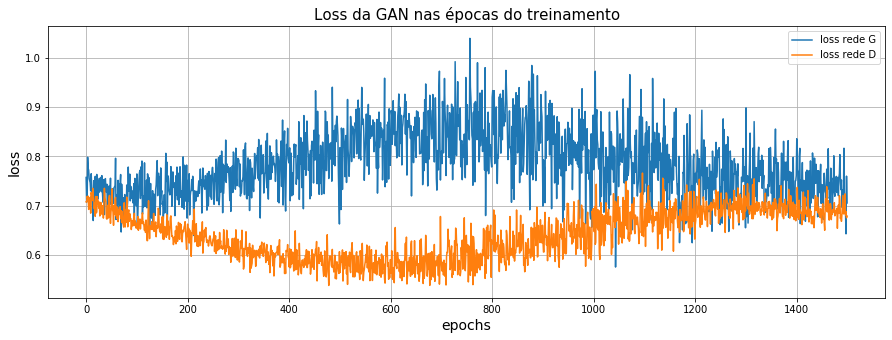

In [21]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

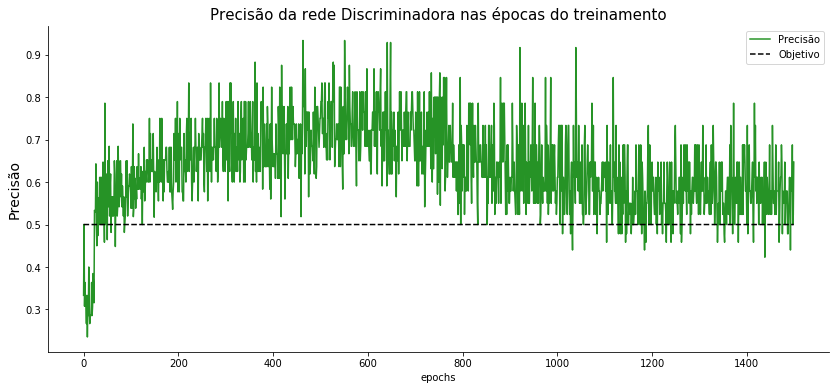

In [22]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

(20, 2) (300, 2)


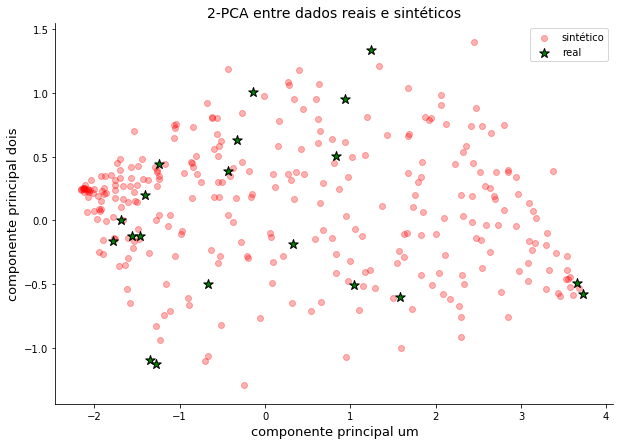

In [23]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [24]:
score = []
for i in range(10000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(precision_score(y_test, y_predict))

In [294]:
def boxtplot_values(v):
    """
    return the values to plot a boxplot with ouliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]
    
    return [lower, q25, q50, q75, upper], outliers

In [302]:
boxtplot_values(np.array(score))

([0.39285714285714285,
  0.5238095238095238,
  0.5789473684210527,
  0.6111111111111112,
  0.7420634920634921],
 array([0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
        0.84615385, 0.78571429, 0.78571429, 0.84615385, 0.78571429,
        0.78571429, 0.78571429, 0.78571429, 0.84615385, 0.78571429,
        0.78571429, 0.84615385, 0.78571429, 0.78571429, 0.78571429,
        0.84615385, 0.78571429, 0.78571429, 0.84615385, 0.78571429,
        0.84615385, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
        0.78571429, 0.84615385, 0.78571429, 0.84615385, 0.78571429,
        0.78571429, 0.78571429, 0.78571429, 0.91666667, 0.78571429,
        0.78571429, 0.78571429, 0.84615385, 0.84615385, 0.84615385,
        0.84615385, 0.84615385, 0.78571429, 0.84615385, 0.78571429,
        0.84615385, 0.78571429, 0.78571429, 0.84615385, 0.78571429,
        0.78571429, 0.84615385, 0.84615385, 0.78571429, 0.78571429,
        0.78571429, 0.78571429, 0.78571429, 0.78571429, 0.78571429,
    

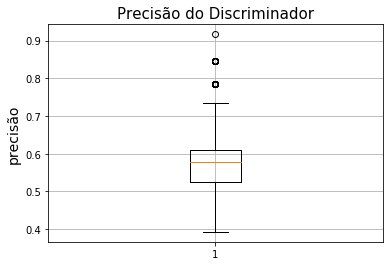

In [258]:
plt.title("Precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [26]:
np.mean(score), np.std(score), np.median(score)

(0.5743966776242584, 0.06708853491218379, 0.5789473684210527)

In [27]:
X_train.shape

(20, 9)

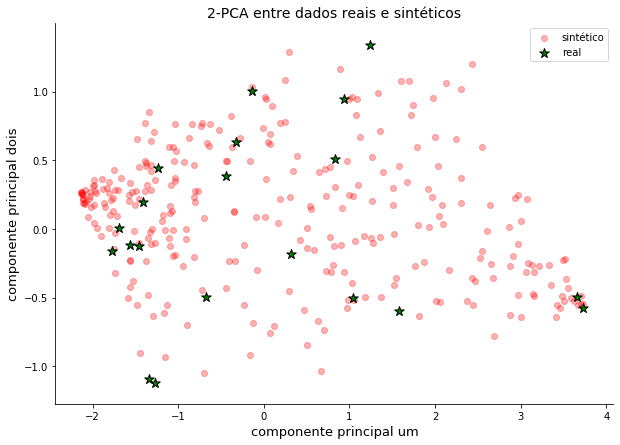

In [28]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [29]:
def best_sample(generator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj.inverse_transform(x_pred)
        #coefficient of variation
        cv = np.mean(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1))
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

In [30]:
t_i = time()
dt_cv, best_idx = best_sample(G, 300, 2000, noise_input)
t_f = time()
print("tempo de execuçฺão: ", (t_f-t_i), "[s]")

tempo de execuçฺão:  11.337680339813232 [s]


In [31]:
dt_cv[best_idx][0], best_idx

(0.14414518666182607, 859)

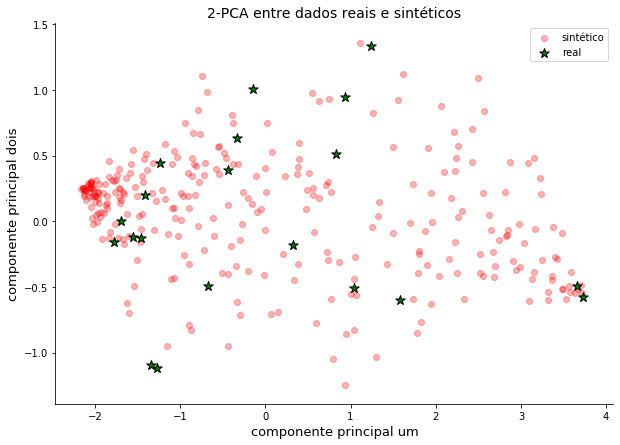

In [32]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(dt_cv[best_idx][1])

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [33]:
X_nov = np.concatenate((X_train[:14], dt_cv[0][1]))
X_nov.shape

(314, 9)

### One-class classification with SVM

In [69]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.0131, gamma="scale").fit(X_nov)

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9681528662420382
score nos genes de referência de treinamento:  0.9285714285714286
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.9


In [35]:
#gan.save("./data/best_gan.h5")

In [36]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [37]:
predict_cand = clf.predict(X_cand)

In [38]:
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

((717, 9), (3468, 9))

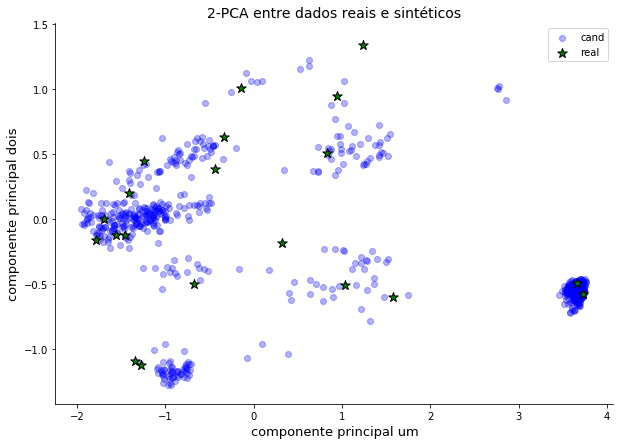

In [39]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [40]:
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

redução do  82.94887039239 % no processo de escolha de candidatos


In [41]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [42]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242
thrW,-0.198341,-0.156393,-0.103735,-0.003529,-0.075905,-0.175493,-0.166364,1.018885,-0.263904


In [43]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [44]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060


## Isolation Forest

In [255]:
from sklearn.ensemble import IsolationForest

clf2 = IsolationForest(n_estimators=100, contamination=0, random_state=False,
                      behaviour="new", n_jobs=2, warm_start=True)
clf2.fit(X_nov)

print("score no treinamento: ", np.mean(clf2.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf2.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf2.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf2.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.95


In [256]:
predict_cand = clf2.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(2187, 9) (1998, 9)
redução do  47.990487514863254 % no processo de escolha de candidatos


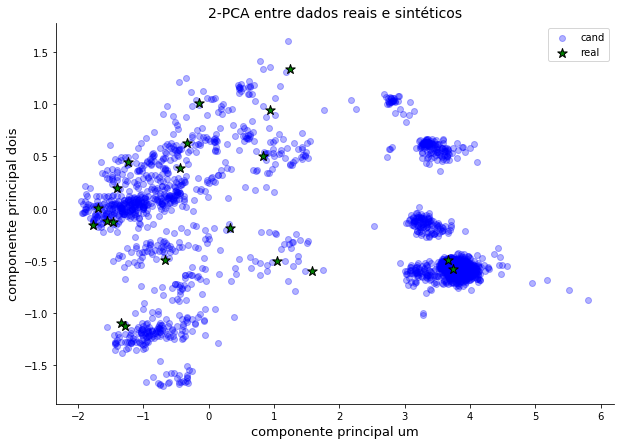

In [257]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [226]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
dtpB,-0.790432,-0.815620,0.621418,0.649137,0.668417,0.679104,0.613943,0.632987,0.645587
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutM,0.599078,0.559825,-0.900217,-0.902955,-0.954312,0.608285,0.536511,0.613976,0.614953
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rhsB,-1.108080,-1.105353,-1.182963,-1.163305,-1.253801,-1.186140,-1.169367,0.366631,-1.099400


In [227]:
print(cand.loc[rg_edi].dropna().shape[0])
cand.loc[rg_edi].dropna()

10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
efp,0.883929,0.893426,0.986886,0.953313,0.964894,0.900637,-0.666888,0.658397,0.797629
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
prc,0.701789,0.687073,0.768016,0.716171,0.720595,0.659306,-0.893690,-0.953165,0.564771
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
rimP,-0.661678,0.776155,0.880130,0.877383,0.870669,0.813908,0.679395,0.567525,-0.761204
rpsO,0.938523,0.932230,-0.408265,-0.417435,-0.436328,0.963185,0.966226,0.727576,0.862091
rpsU,1.003203,0.996594,-0.384078,-0.383782,1.033621,0.992408,0.946259,0.762402,0.909104


## LocalOutlierFactor

In [250]:
from sklearn.neighbors import LocalOutlierFactor

clf3 = LocalOutlierFactor(n_neighbors=2, contamination=0.00001, novelty=True,)
clf3.fit(X_nov)

print("score no treinamento: ", np.mean(clf3.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf3.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf3.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf3.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [251]:
predict_cand = clf3.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(3115, 9) (1070, 9)
redução do  25.921521997621877 % no processo de escolha de candidatos


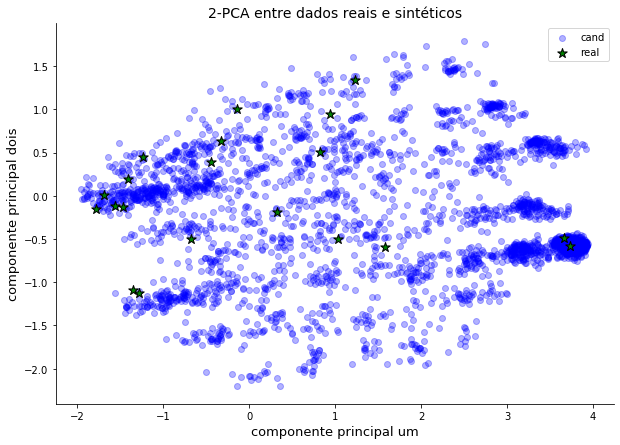

In [252]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [253]:
print(cand.loc[rg_moose].dropna().shape[0])
print(cand.loc[rg_edi].dropna().shape[0])

20
17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [154]:
class one_class_gan:
    
    def __init__(self, X_train, noise_input, epochs):
        self.X_train = X_train
        self.noise_input = noise_input
        self.epochs = epochs
        #building gan
        optG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/self.epochs)
        optD = SGD(lr=0.00021, momentum=0.92, decay=0.0001/self.epochs)
        self.G = self.generator(optG)
        self.D = self.discriminator(optD)
        self.gan = self.build_gan(self.G, self.D, optG) 
        
    def generator(self, opt):
        model = Sequential()
        model.add(Dense(30, input_shape=(self.noise_input,)))
        model.add(Dense(30))
        model.add(Dense(X_train.shape[1], activation="tanh"))
        model.compile(loss="binary_crossentropy",
                      optimizer=opt)
        return model
    
    def discriminator(self, opt):
        model = Sequential()
        model.add(Dense(128, input_shape=(self.X_train.shape[1],)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(64))
        model.add(Dense(32))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
        return model
    
    def build_gan(self, G, D, opt):
        model = Sequential()
        model.add(G)
        D.trainable = False
        model.add(D)
        model.compile(loss="binary_crossentropy", optimizer=opt)
        return model
        
    def get_batches(self, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(self.X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > self.X_train.shape[0]:
                lim_s = self.X_train.shape[0]
            batches.append(self.X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
        return batches

    def train(self, epochs, batch_size):       
        g_loss = []
        d_loss = []
        precision = []
        for epoch in range(epochs):
            batches = self.get_batches(batch_size)
            count_b = 0
            t_i = time()
            d_bacth_loss = []
            g_bacth_loss = []
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_data = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_data))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #misturar os dados
                #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
                #treino do discriminador
                d_bacth_loss.append(self.D.train_on_batch(x_combined_batch, y_combined_batch)[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))
                g_bacth_loss.append(self.gan.train_on_batch(noise, y_mislabled))

            #precision
            X_sint = self.G.predict(np.random.normal(0, 1, (self.X_train.shape[0], self.noise_input)))
            X_comb = np.concatenate((self.X_train, X_sint))
            y_comb = np.concatenate((np.ones((self.X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
            y_predict = self.D.predict_classes(X_comb)
            #f1_lag = f1_score(y_test, y_predict)
            precision.append(precision_score(y_comb, y_predict))
            #fscore.append(f1_lag)
            t_f = time()
            t = t_f - t_i
            t_i = time()
            #d_loss.append(np.mean(np.array(d_bacth_loss)))
            #g_loss.append(np.mean(np.array(g_bacth_loss)))
            d_loss.append(d_bacth_loss[-1])
            g_loss.append(g_bacth_loss[-1])
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                       % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
            #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
            #    break
        return g_loss, d_loss, precision

In [155]:
X_nov.shape

(314, 9)

In [156]:
obj_oc = one_class_gan(X_nov, 50, 1000)
gloss, dloss, d_precision  = obj_oc.train(1000, batch_size=int(X_nov.shape[0]))

epoch:[1/1000] [Discriminator::d_loss: 0.746245],[Generator::loss: 0.860223], 1.930268[sec]
epoch:[2/1000] [Discriminator::d_loss: 0.740365],[Generator::loss: 0.873091], 0.031229[sec]
epoch:[3/1000] [Discriminator::d_loss: 0.748399],[Generator::loss: 0.902758], 0.031521[sec]
epoch:[4/1000] [Discriminator::d_loss: 0.745964],[Generator::loss: 0.878662], 0.031005[sec]
epoch:[5/1000] [Discriminator::d_loss: 0.741356],[Generator::loss: 0.887164], 0.031445[sec]
epoch:[6/1000] [Discriminator::d_loss: 0.739816],[Generator::loss: 0.865471], 0.029828[sec]
epoch:[7/1000] [Discriminator::d_loss: 0.740039],[Generator::loss: 0.882209], 0.029025[sec]
epoch:[8/1000] [Discriminator::d_loss: 0.743635],[Generator::loss: 0.859898], 0.032923[sec]
epoch:[9/1000] [Discriminator::d_loss: 0.737955],[Generator::loss: 0.871129], 0.038237[sec]
epoch:[10/1000] [Discriminator::d_loss: 0.732992],[Generator::loss: 0.849895], 0.028504[sec]
epoch:[11/1000] [Discriminator::d_loss: 0.745697],[Generator::loss: 0.892264], 

epoch:[92/1000] [Discriminator::d_loss: 0.668491],[Generator::loss: 0.770164], 0.040072[sec]
epoch:[93/1000] [Discriminator::d_loss: 0.668159],[Generator::loss: 0.792502], 0.033797[sec]
epoch:[94/1000] [Discriminator::d_loss: 0.674871],[Generator::loss: 0.795097], 0.034383[sec]
epoch:[95/1000] [Discriminator::d_loss: 0.671822],[Generator::loss: 0.780956], 0.030917[sec]
epoch:[96/1000] [Discriminator::d_loss: 0.663923],[Generator::loss: 0.773816], 0.028524[sec]
epoch:[97/1000] [Discriminator::d_loss: 0.673712],[Generator::loss: 0.785451], 0.028644[sec]
epoch:[98/1000] [Discriminator::d_loss: 0.660476],[Generator::loss: 0.779084], 0.028720[sec]
epoch:[99/1000] [Discriminator::d_loss: 0.672668],[Generator::loss: 0.776520], 0.036183[sec]
epoch:[100/1000] [Discriminator::d_loss: 0.668647],[Generator::loss: 0.769589], 0.029272[sec]
epoch:[101/1000] [Discriminator::d_loss: 0.664568],[Generator::loss: 0.779865], 0.028601[sec]
epoch:[102/1000] [Discriminator::d_loss: 0.660517],[Generator::loss:

epoch:[183/1000] [Discriminator::d_loss: 0.630127],[Generator::loss: 0.789274], 0.035751[sec]
epoch:[184/1000] [Discriminator::d_loss: 0.633323],[Generator::loss: 0.776569], 0.034500[sec]
epoch:[185/1000] [Discriminator::d_loss: 0.625448],[Generator::loss: 0.775465], 0.028606[sec]
epoch:[186/1000] [Discriminator::d_loss: 0.634966],[Generator::loss: 0.764065], 0.028067[sec]
epoch:[187/1000] [Discriminator::d_loss: 0.635576],[Generator::loss: 0.786489], 0.028328[sec]
epoch:[188/1000] [Discriminator::d_loss: 0.638709],[Generator::loss: 0.784521], 0.028665[sec]
epoch:[189/1000] [Discriminator::d_loss: 0.633055],[Generator::loss: 0.779182], 0.027912[sec]
epoch:[190/1000] [Discriminator::d_loss: 0.637991],[Generator::loss: 0.787109], 0.031408[sec]
epoch:[191/1000] [Discriminator::d_loss: 0.634035],[Generator::loss: 0.772943], 0.033014[sec]
epoch:[192/1000] [Discriminator::d_loss: 0.630496],[Generator::loss: 0.802919], 0.028116[sec]
epoch:[193/1000] [Discriminator::d_loss: 0.640743],[Generato

epoch:[273/1000] [Discriminator::d_loss: 0.611936],[Generator::loss: 0.792530], 0.030707[sec]
epoch:[274/1000] [Discriminator::d_loss: 0.601125],[Generator::loss: 0.791718], 0.032902[sec]
epoch:[275/1000] [Discriminator::d_loss: 0.603577],[Generator::loss: 0.817779], 0.028722[sec]
epoch:[276/1000] [Discriminator::d_loss: 0.614395],[Generator::loss: 0.782845], 0.028118[sec]
epoch:[277/1000] [Discriminator::d_loss: 0.619263],[Generator::loss: 0.774457], 0.028457[sec]
epoch:[278/1000] [Discriminator::d_loss: 0.609266],[Generator::loss: 0.789328], 0.028690[sec]
epoch:[279/1000] [Discriminator::d_loss: 0.620612],[Generator::loss: 0.788637], 0.029216[sec]
epoch:[280/1000] [Discriminator::d_loss: 0.611764],[Generator::loss: 0.805794], 0.038996[sec]
epoch:[281/1000] [Discriminator::d_loss: 0.619166],[Generator::loss: 0.802913], 0.035741[sec]
epoch:[282/1000] [Discriminator::d_loss: 0.623727],[Generator::loss: 0.795872], 0.029810[sec]
epoch:[283/1000] [Discriminator::d_loss: 0.614697],[Generato

epoch:[366/1000] [Discriminator::d_loss: 0.594193],[Generator::loss: 0.820352], 0.035710[sec]
epoch:[367/1000] [Discriminator::d_loss: 0.603797],[Generator::loss: 0.806911], 0.028681[sec]
epoch:[368/1000] [Discriminator::d_loss: 0.600800],[Generator::loss: 0.832233], 0.028423[sec]
epoch:[369/1000] [Discriminator::d_loss: 0.612345],[Generator::loss: 0.846448], 0.028194[sec]
epoch:[370/1000] [Discriminator::d_loss: 0.601696],[Generator::loss: 0.854197], 0.028432[sec]
epoch:[371/1000] [Discriminator::d_loss: 0.599297],[Generator::loss: 0.827697], 0.028231[sec]
epoch:[372/1000] [Discriminator::d_loss: 0.598163],[Generator::loss: 0.821190], 0.027991[sec]
epoch:[373/1000] [Discriminator::d_loss: 0.602412],[Generator::loss: 0.822970], 0.027811[sec]
epoch:[374/1000] [Discriminator::d_loss: 0.602343],[Generator::loss: 0.803259], 0.034872[sec]
epoch:[375/1000] [Discriminator::d_loss: 0.602546],[Generator::loss: 0.808376], 0.029219[sec]
epoch:[376/1000] [Discriminator::d_loss: 0.594167],[Generato

epoch:[455/1000] [Discriminator::d_loss: 0.597345],[Generator::loss: 0.869968], 0.057521[sec]
epoch:[456/1000] [Discriminator::d_loss: 0.579352],[Generator::loss: 0.850302], 0.055524[sec]
epoch:[457/1000] [Discriminator::d_loss: 0.600926],[Generator::loss: 0.830175], 0.061816[sec]
epoch:[458/1000] [Discriminator::d_loss: 0.593250],[Generator::loss: 0.824044], 0.043757[sec]
epoch:[459/1000] [Discriminator::d_loss: 0.576606],[Generator::loss: 0.833591], 0.031454[sec]
epoch:[460/1000] [Discriminator::d_loss: 0.595502],[Generator::loss: 0.827471], 0.053752[sec]
epoch:[461/1000] [Discriminator::d_loss: 0.585673],[Generator::loss: 0.829274], 0.044130[sec]
epoch:[462/1000] [Discriminator::d_loss: 0.594883],[Generator::loss: 0.858246], 0.037819[sec]
epoch:[463/1000] [Discriminator::d_loss: 0.576726],[Generator::loss: 0.849462], 0.048540[sec]
epoch:[464/1000] [Discriminator::d_loss: 0.580452],[Generator::loss: 0.838950], 0.036973[sec]
epoch:[465/1000] [Discriminator::d_loss: 0.587953],[Generato

epoch:[548/1000] [Discriminator::d_loss: 0.576298],[Generator::loss: 0.862914], 0.063190[sec]
epoch:[549/1000] [Discriminator::d_loss: 0.572611],[Generator::loss: 0.874074], 0.058437[sec]
epoch:[550/1000] [Discriminator::d_loss: 0.582935],[Generator::loss: 0.859206], 0.059222[sec]
epoch:[551/1000] [Discriminator::d_loss: 0.584263],[Generator::loss: 0.847397], 0.031224[sec]
epoch:[552/1000] [Discriminator::d_loss: 0.588994],[Generator::loss: 0.833101], 0.028154[sec]
epoch:[553/1000] [Discriminator::d_loss: 0.579975],[Generator::loss: 0.810964], 0.034197[sec]
epoch:[554/1000] [Discriminator::d_loss: 0.568848],[Generator::loss: 0.859562], 0.034598[sec]
epoch:[555/1000] [Discriminator::d_loss: 0.582876],[Generator::loss: 0.818677], 0.029262[sec]
epoch:[556/1000] [Discriminator::d_loss: 0.581828],[Generator::loss: 0.847107], 0.028605[sec]
epoch:[557/1000] [Discriminator::d_loss: 0.569553],[Generator::loss: 0.856633], 0.028262[sec]
epoch:[558/1000] [Discriminator::d_loss: 0.584717],[Generato

epoch:[642/1000] [Discriminator::d_loss: 0.573168],[Generator::loss: 0.844857], 0.043798[sec]
epoch:[643/1000] [Discriminator::d_loss: 0.569933],[Generator::loss: 0.861991], 0.031276[sec]
epoch:[644/1000] [Discriminator::d_loss: 0.576534],[Generator::loss: 0.853919], 0.029686[sec]
epoch:[645/1000] [Discriminator::d_loss: 0.564274],[Generator::loss: 0.863864], 0.029221[sec]
epoch:[646/1000] [Discriminator::d_loss: 0.568633],[Generator::loss: 0.881825], 0.029371[sec]
epoch:[647/1000] [Discriminator::d_loss: 0.583529],[Generator::loss: 0.899321], 0.029746[sec]
epoch:[648/1000] [Discriminator::d_loss: 0.583146],[Generator::loss: 0.842704], 0.029701[sec]
epoch:[649/1000] [Discriminator::d_loss: 0.569734],[Generator::loss: 0.860586], 0.038804[sec]
epoch:[650/1000] [Discriminator::d_loss: 0.570809],[Generator::loss: 0.891290], 0.037782[sec]
epoch:[651/1000] [Discriminator::d_loss: 0.580916],[Generator::loss: 0.863038], 0.029677[sec]
epoch:[652/1000] [Discriminator::d_loss: 0.574856],[Generato

epoch:[733/1000] [Discriminator::d_loss: 0.574266],[Generator::loss: 0.867837], 0.033404[sec]
epoch:[734/1000] [Discriminator::d_loss: 0.573628],[Generator::loss: 0.860497], 0.056169[sec]
epoch:[735/1000] [Discriminator::d_loss: 0.565907],[Generator::loss: 0.875685], 0.054189[sec]
epoch:[736/1000] [Discriminator::d_loss: 0.561576],[Generator::loss: 0.853484], 0.049826[sec]
epoch:[737/1000] [Discriminator::d_loss: 0.581940],[Generator::loss: 0.883906], 0.031902[sec]
epoch:[738/1000] [Discriminator::d_loss: 0.583284],[Generator::loss: 0.858480], 0.037786[sec]
epoch:[739/1000] [Discriminator::d_loss: 0.580848],[Generator::loss: 0.868067], 0.029289[sec]
epoch:[740/1000] [Discriminator::d_loss: 0.572089],[Generator::loss: 0.857667], 0.029251[sec]
epoch:[741/1000] [Discriminator::d_loss: 0.562960],[Generator::loss: 0.870371], 0.029215[sec]
epoch:[742/1000] [Discriminator::d_loss: 0.593431],[Generator::loss: 0.869779], 0.029026[sec]
epoch:[743/1000] [Discriminator::d_loss: 0.574447],[Generato

epoch:[822/1000] [Discriminator::d_loss: 0.566237],[Generator::loss: 0.890377], 0.029127[sec]
epoch:[823/1000] [Discriminator::d_loss: 0.575509],[Generator::loss: 0.869005], 0.032736[sec]
epoch:[824/1000] [Discriminator::d_loss: 0.592644],[Generator::loss: 0.906220], 0.028920[sec]
epoch:[825/1000] [Discriminator::d_loss: 0.570785],[Generator::loss: 0.877945], 0.028919[sec]
epoch:[826/1000] [Discriminator::d_loss: 0.571615],[Generator::loss: 0.870386], 0.028424[sec]
epoch:[827/1000] [Discriminator::d_loss: 0.572146],[Generator::loss: 0.914298], 0.028231[sec]
epoch:[828/1000] [Discriminator::d_loss: 0.574680],[Generator::loss: 0.876985], 0.028346[sec]
epoch:[829/1000] [Discriminator::d_loss: 0.577047],[Generator::loss: 0.879536], 0.029092[sec]
epoch:[830/1000] [Discriminator::d_loss: 0.574611],[Generator::loss: 0.881863], 0.033524[sec]
epoch:[831/1000] [Discriminator::d_loss: 0.580498],[Generator::loss: 0.870103], 0.029768[sec]
epoch:[832/1000] [Discriminator::d_loss: 0.577555],[Generato

epoch:[913/1000] [Discriminator::d_loss: 0.584998],[Generator::loss: 0.901712], 0.034184[sec]
epoch:[914/1000] [Discriminator::d_loss: 0.587001],[Generator::loss: 0.865476], 0.035640[sec]
epoch:[915/1000] [Discriminator::d_loss: 0.564490],[Generator::loss: 0.887608], 0.029130[sec]
epoch:[916/1000] [Discriminator::d_loss: 0.573451],[Generator::loss: 0.863777], 0.029696[sec]
epoch:[917/1000] [Discriminator::d_loss: 0.600882],[Generator::loss: 0.886710], 0.028510[sec]
epoch:[918/1000] [Discriminator::d_loss: 0.581894],[Generator::loss: 0.865691], 0.028248[sec]
epoch:[919/1000] [Discriminator::d_loss: 0.578947],[Generator::loss: 0.872884], 0.029007[sec]
epoch:[920/1000] [Discriminator::d_loss: 0.586104],[Generator::loss: 0.880017], 0.033375[sec]
epoch:[921/1000] [Discriminator::d_loss: 0.592893],[Generator::loss: 0.878161], 0.031502[sec]
epoch:[922/1000] [Discriminator::d_loss: 0.582204],[Generator::loss: 0.891742], 0.028577[sec]
epoch:[923/1000] [Discriminator::d_loss: 0.578287],[Generato

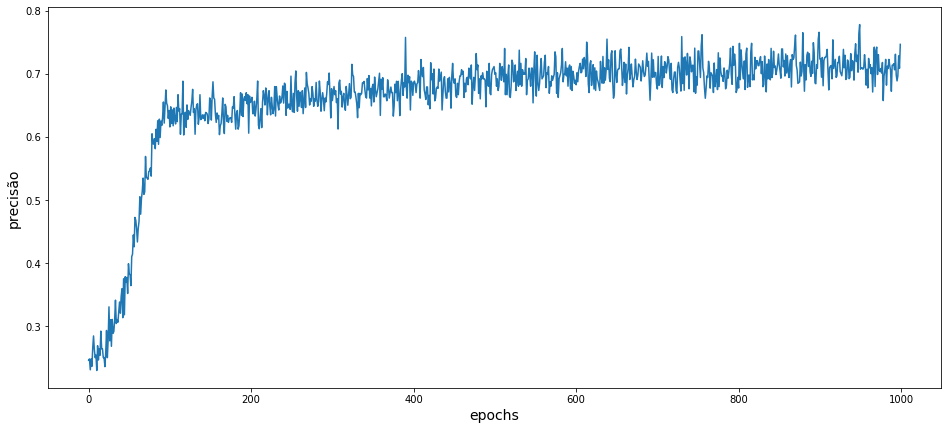

In [157]:
plt.figure(figsize=(16,7))
plt.xlabel("epochs", fontsize=14)
plt.ylabel("precisão", fontsize=14)
plt.plot(range(len(d_precision)), d_precision);

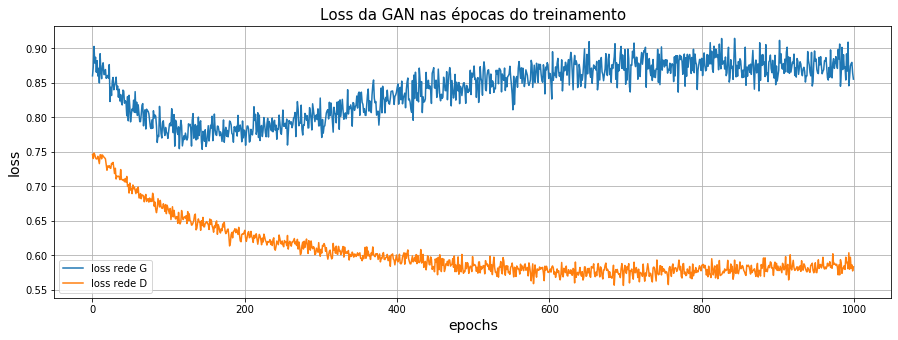

In [158]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(gloss)), gloss, label="loss rede G")
plt.plot(range(len(dloss)), dloss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

In [160]:
np.mean(obj_oc.D.predict_classes(X_train)==1)

0.6

In [161]:
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669
